In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
from tensorflow.image import ssim
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Load data

In [2]:
(X_train, _), (X_test, _) = tf.keras.datasets.cifar10.load_data()

for faster execution, I just used a chunk of the original data, you can skip this cell if you want to use the whole cifar10 data.

In [3]:
X_train = X_train[:5000]
X_test = X_test[:100]

# Corrupt data

In [4]:
def corrupt_data(data, max_no_blocks, block_size=3):

  im_size = data.shape[1:]
  data_incomplete = copy.copy(data)

  for j in range(len(data)):
    for i in range(max_no_blocks):
      xc = np.random.randint(block_size//2, im_size[0]-block_size//2)
      yc = np.random.randint(block_size//2, im_size[1]-block_size//2)

      data_incomplete[j, xc-block_size//2:xc+block_size//2,
                      yc-block_size//2:yc+block_size//2] = 0

  
  return data_incomplete

Corrupt the dataset with max_no_blocks ∈ {10, 50, 100} (for a fixed
block_size=3)

In [5]:
X_train_corrupted = {'10': corrupt_data(X_train, 10), '50': corrupt_data(X_train, 50), '100': corrupt_data(X_train, 100)}
X_test_corrupted = {'10': corrupt_data(X_test, 10), '50': corrupt_data(X_test, 50), '100': corrupt_data(X_test, 100)}

Print a sample of corrupted data for each number of blocks.

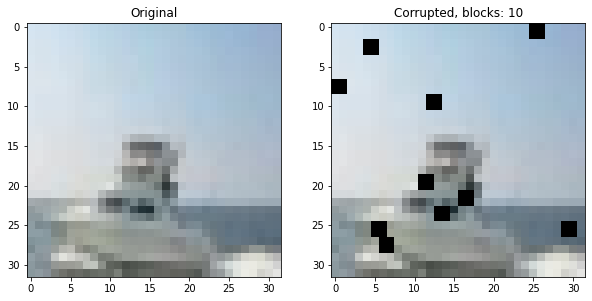

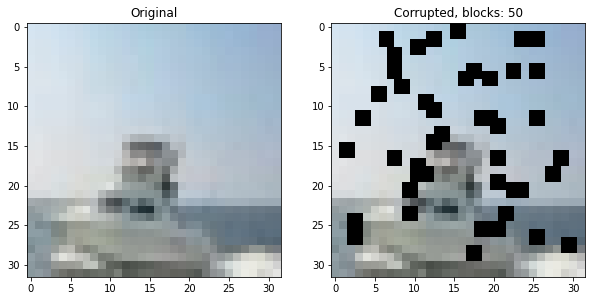

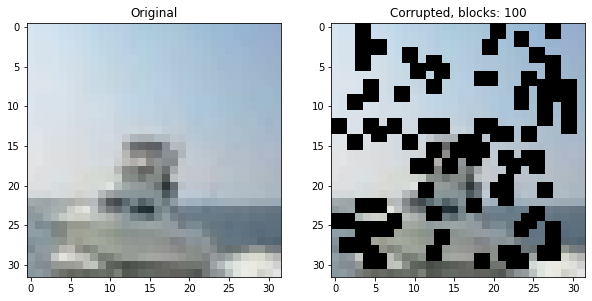

In [6]:
for name, corrupted in X_train_corrupted.items():
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  plt.imshow(X_train[100,], cmap=plt.cm.gray)
  plt.title('Original')
  plt.subplot(122)
  plt.imshow(corrupted[100,], cmap=plt.cm.gray)
  plt.title('Corrupted, blocks: '+name)

# Autoencoder

I'm going to use encoder-decoder method to solve this problem.

Scale the dataset.

In [7]:
X_train = tf.cast(X_train, tf.float32)/255
X_test = tf.cast(X_test, tf.float32)/255

for name in X_train_corrupted:
  X_train_corrupted[name] = tf.cast(X_train_corrupted[name], tf.float32)/255
  X_test_corrupted[name] = tf.cast(X_test_corrupted[name], tf.float32)/255

I used my autoencoder code from assignment 6.

In [8]:
class AdversarialAE(Model):
  def __init__(self, img_shape, filters=[64,128]):
    super(AdversarialAE, self).__init__()
    self.img_shape = img_shape
    self.filters = filters

    self.encoder = self._build_encoder()
    self.decoder = self._build_decoder()

  def _build_encoder(self):

    inputs = x = tf.keras.layers.Input(shape=self.img_shape)
    for filter in self.filters:
      x = tf.keras.layers.Conv2D(filter, 3, strides=2,
                                 padding='same')(x)
      if not filter==self.filters[-1]:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    self.shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    out = x

    return tf.keras.models.Model(inputs, out)


  def _build_decoder(self):

    inputs = x = tf.keras.layers.Input(shape=self.shape_before_flatten)

    filters = copy.copy(self.filters)
    filters.reverse()
    for filter in filters:
      x = tf.keras.layers.Conv2DTranspose(filter, 3, strides=2,
                                 padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.LeakyReLU(0.2)(x)
    out = tf.keras.layers.Conv2D(self.img_shape[-1], 3, activation='sigmoid',
                                          padding='same')(x)

    return tf.keras.models.Model(inputs, out)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

acai = AdversarialAE(img_shape=X_train.shape[1:])
acai.compile(optimizer='adam', loss="mse")

for each version of corrupted data, the autoencoder is fitted on train data, and will do prediction on test data. The loss and predictions are saved for comparisons.

In [9]:
reconstrucreds = {}
loss = {}
for name in X_train_corrupted:
  train =  X_train_corrupted[name]
  test =  X_test_corrupted[name]

  acai.fit(train, X_train,
                epochs=4,
                shuffle=True,
                validation_data=(test, X_test))
  
  reconstrucreds[name] = acai(test)
  loss[name] = acai.evaluate(test, X_test)

Epoch 1/4
157/157 [==============================] - 55s 347ms/step - loss: 0.0078 - val_loss: 0.0509
Epoch 2/4
157/157 [==============================] - 54s 343ms/step - loss: 0.0036 - val_loss: 0.0297
Epoch 3/4
157/157 [==============================] - 55s 352ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 4/4
4/4 [==============================] - 0s 104ms/step - loss: 0.0019
Epoch 1/4
157/157 [==============================] - 55s 352ms/step - loss: 0.0039 - val_loss: 0.0103
Epoch 2/4
157/157 [==============================] - 54s 344ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 3/4
157/157 [==============================] - 53s 338ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/4
4/4 [==============================] - 0s 82ms/step - loss: 0.0021
Epoch 1/4
157/157 [==============================] - 53s 340ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 2/4
157/157 [==============================] - 52s 332ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 3/4
157/157 [==========

The original, corrupted and reconstructed image for 10th sample in test-data is plotted for every version of corruption.

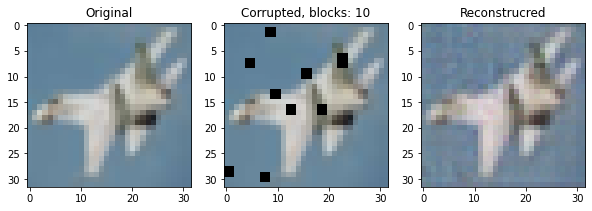

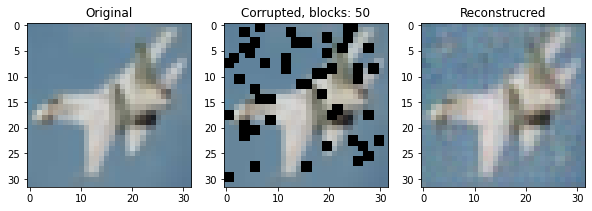

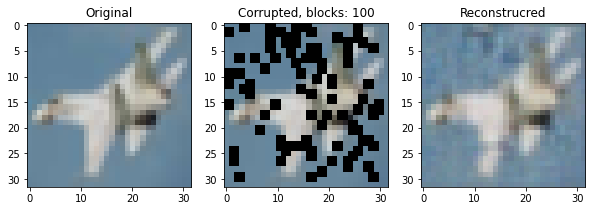

In [10]:
for name in reconstrucreds:  
  plt.figure(figsize=(10,5))
  plt.subplot(131)
  plt.imshow(X_test[10,], cmap=plt.cm.gray)
  plt.title('Original')

  plt.subplot(132)
  plt.imshow(X_test_corrupted[name][10,], cmap=plt.cm.gray)
  plt.title('Corrupted, blocks: '+name)

  plt.subplot(133)
  plt.imshow(reconstrucreds[name][10,], cmap=plt.cm.gray)
  plt.title('Reconstrucred')

The loss and ssim of each model is shown below

In [18]:
for name in X_train_corrupted:
  # ssim between the original image and it's reconstructed version based on corruption
  print('ssim for', name, 'block is: ', np.round(ssim(reconstrucreds[name], X_test, max_val=1.0).numpy().mean(),2))
  print('loss for', name, 'block is: ', np.round(loss[name], 4))
  print()

ssim for 10 block is:  0.92
loss for 10 block is:  0.0019

ssim for 50 block is:  0.91
loss for 50 block is:  0.0021

ssim for 100 block is:  0.86
loss for 100 block is:  0.0032



As you can see, the more blocks in corruption, the more is loss and the less is the similarity between reconstructed version to the original one. So the highest similarity is for when maximum number of corruption blocks is 10, because more space in the image is present for the model to learn its structure.